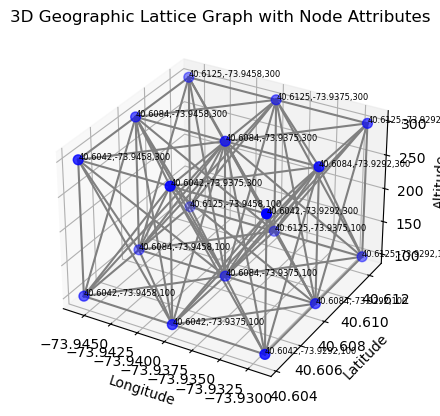

In [1]:
# Import required libraries
import networkx as nx              # For creating and managing the graph
from geopy.distance import geodesic # For calculating 2D geodesic distances on Earth's surface
import numpy as np                 # For numerical operations, including 3D distance calculations
import matplotlib.pyplot as plt    # For plotting the graph
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting capabilities in Matplotlib

# Define the bounding box for geographic coordinates
# These are the latitude and longitude boundaries for the 2D grid
min_lat, max_lat = 40.6042, 40.6125  # Minimum and maximum latitude (degrees)
min_lon, max_lon = -73.9458, -73.9292  # Minimum and maximum longitude (degrees)
min_alt, max_alt = 100, 300  # Minimum and maximum altitude (meters) for two layers

# Define grid dimensions
# n_lat x n_lon x n_alt creates a 3D grid of nodes
n_lat, n_lon, n_alt = 3, 3, 2  # 10 rows, 10 columns, 2 altitude layers

# Generate grid points using NumPy's linspace
# linspace(start, stop, num) creates an array of 'num' evenly spaced values from 'start' to 'stop'
lats = np.linspace(min_lat, max_lat, n_lat)  # Array of latitude values
lons = np.linspace(min_lon, max_lon, n_lon)  # Array of longitude values
alts = np.linspace(min_alt, max_alt, n_alt)  # Array of altitude values (0, 100 for two layers)

# Create node identifiers and their geographic positions
# Nodes are identified by (i, j, k) tuples, where i is row, j is column, k is layer
# pos maps each node to its (latitude, longitude, altitude) coordinates
nodes = [(i, j, k) for i in range(n_lat) for j in range(n_lon) for k in range(n_alt)]
pos = {(i, j, k): (lats[i], lons[j], alts[k]) for i in range(n_lat) for j in range(n_lon) for k in range(n_alt)}

# Create an empty undirected graph using NetworkX
G = nx.Graph()  # nx.Graph() initializes an undirected graph

# Add all nodes to the graph
# G.add_nodes_from(iterable) adds each element in the iterable as a node
G.add_nodes_from(nodes)

# Define a function to calculate the slant range (3D distance) between two points
# Input: p1, p2 are tuples of (latitude, longitude, altitude)
# Output: Euclidean distance in meters, combining 2D geodesic distance and altitude difference
def slant_range(p1, p2):
    dist_2d = geodesic(p1[:2], p2[:2]).meters  # geodesic((lat, lon), (lat, lon)) returns 2D distance
    dalt = p2[2] - p1[2]  # Altitude difference (meters)
    return np.sqrt(dist_2d**2 + dalt**2)  # np.sqrt computes the square root for 3D distance

# Add edges to connect each node to all its neighbors, including diagonals
# Iterate over all nodes (i, j, k)
# For each node, connect to neighbors by varying indices by -1, 0, or 1
for i in range(n_lat):
    for j in range(n_lon):
        for k in range(n_alt):
            for di in [-1, 0, 1]:  # Possible changes in row index
                for dj in [-1, 0, 1]:  # Possible changes in column index
                    for dk in [-1, 0, 1]:  # Possible changes in layer index
                        if di == dj == dk == 0:  # Skip self-loops (same node)
                            continue
                        ni, nj, nk = i + di, j + dj, k + dk  # Neighbor's coordinates
                        # Check if neighbor is within grid bounds
                        if 0 <= ni < n_lat and 0 <= nj < n_lon and 0 <= nk < n_alt:
                            u, v = (i, j, k), (ni, nj, nk)  # Current node and neighbor
                            dist = slant_range(pos[u], pos[v])  # Calculate distance
                            G.add_edge(u, v, weight=dist)  # Add edge with distance as weight

# Set node attributes for geographic coordinates
# nx.set_node_attributes(G, values, name) assigns the 'values' dict to attribute 'name' for each node
nx.set_node_attributes(G, pos, 'pos')

# Create a 3D plot using Matplotlib
fig = plt.figure()  # Initialize a new figure
ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot (111 means 1x1 grid, 1st subplot)

# Extract coordinates for plotting
# xs, ys, zs are lists of longitude, latitude, and altitude for all nodes
xs, ys, zs = [], [], []
for node in G.nodes():
    lat, lon, alt = pos[node]  # Get node's coordinates
    xs.append(lon)  # Longitude as x-axis
    ys.append(lat)  # Latitude as y-axis
    zs.append(alt)  # Altitude as z-axis

# Plot nodes as scatter points
# ax.scatter(x, y, z) plots points in 3D space; c is color, s is size
ax.scatter(xs, ys, zs, c='blue', s=50)

# Plot edges as lines
# For each edge, draw a line between the two nodes' coordinates
for edge in G.edges():
    p1 = pos[edge[0]]  # Coordinates of first node (lat, lon, alt)
    p2 = pos[edge[1]]  # Coordinates of second node
    ax.plot([p1[1], p2[1]], [p1[0], p2[0]], [p1[2], p2[2]], 'gray')  # Plot line (lon, lat, alt)

# Add labels showing (lat, lon, alt) for each node
# ax.text(x, y, z, text) places text at the specified 3D coordinates
for node in G.nodes():
    lat, lon, alt = pos[node]
    ax.text(lon, lat, alt, f"{lat:.4f},{lon:.4f},{alt:.0f}", fontsize=6)

# Set axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Altitude')

# Set plot title
plt.title('3D Geographic Lattice Graph with Node Attributes')

# Display the plot
plt.show()

In [2]:
node = (1, 1, 0)  # Specify node
print(f"Attributes of {node}: {G.nodes[node]}")
print(f"Edges of {node}:")
for u, v, data in G.edges(node, data=True):
    print(f"  {u} -> {v}, Weight: {data['weight']:.2f} meters")

Attributes of (1, 1, 0): {'pos': (40.60835, -73.9375, 100.0)}
Edges of (1, 1, 0):
  (1, 1, 0) -> (0, 0, 0), Weight: 840.14 meters
  (1, 1, 0) -> (0, 0, 1), Weight: 863.61 meters
  (1, 1, 0) -> (0, 1, 0), Weight: 460.84 meters
  (1, 1, 0) -> (0, 1, 1), Weight: 502.37 meters
  (1, 1, 0) -> (0, 2, 0), Weight: 840.14 meters
  (1, 1, 0) -> (0, 2, 1), Weight: 863.61 meters
  (1, 1, 0) -> (1, 0, 0), Weight: 702.44 meters
  (1, 1, 0) -> (1, 0, 1), Weight: 730.36 meters
  (1, 1, 0) -> (1, 1, 1), Weight: 200.00 meters
  (1, 1, 0) -> (1, 2, 0), Weight: 702.44 meters
  (1, 1, 0) -> (1, 2, 1), Weight: 730.36 meters
  (1, 1, 0) -> (2, 0, 0), Weight: 840.10 meters
  (1, 1, 0) -> (2, 0, 1), Weight: 863.58 meters
  (1, 1, 0) -> (2, 1, 0), Weight: 460.84 meters
  (1, 1, 0) -> (2, 1, 1), Weight: 502.37 meters
  (1, 1, 0) -> (2, 2, 0), Weight: 840.10 meters
  (1, 1, 0) -> (2, 2, 1), Weight: 863.58 meters
